# Video Game Sales Analysis

In [1]:
#Import all the required libraries
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Let's get our data and preview it
df = pd.read_csv('Video_Games_Sales.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# It has 16719 rows and 16 columns
df.shape

(16719, 16)

In [4]:
# The Column names
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

### Handling outlier values


[(0.0, 4.0), (50.0, 95.0)]

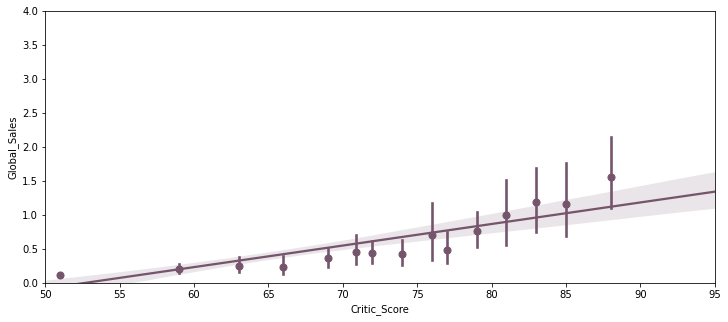

In [5]:
#Outlier is an object that deviates significantly from the rest of objects.
#Let's check the corelation between what we suspect to be, the most obvious pair of dependent and independent variables.
#Plot Corelation bettween Global Sales and Critic Score
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df.loc[df.Year_of_Release >= 2014],
            truncate=True, x_bins=15, color="#75556c").set(ylim=(0, 4), xlim=(50, 95))

#The relationship looks much clearer now. It's interesting how the slope gets steeper in the 80's.
#It seems once a game gets a high critic score, every additional point has a higher impact.

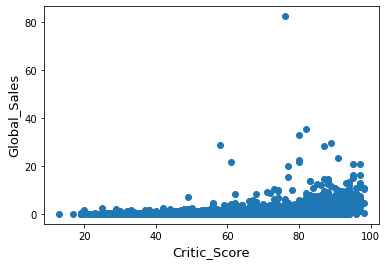

In [6]:
# Handle the outliers of Critic Score
fig, ax = plt.subplots()
ax.scatter(x = df['Critic_Score'], y = df['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()

In [7]:
#There's really only one clear outlier in the dataset, so lets get rid of it
df = df.drop(df[(df['Critic_Score']>60) & (df['Global_Sales']>60)].index)

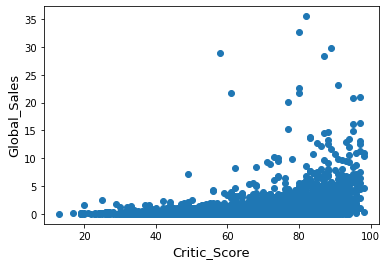

In [8]:
#Now we check the plot again to confirm we are rid of the outlier
fig, ax = plt.subplots()
ax.scatter(x = df['Critic_Score'], y = df['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()


###### If we look at the plot post-outlier removal, it still looks as if though there are outliers in the data. However, removing too many data points that are seemingly outliers may cross over to data tampering, which we don't want to get into. So for now, lets keep the data as it is.

### Handling Missing Values

In [9]:
#Now we will handle missing values
#Let's look at what independent variables we will keep and whether there are N/A values etc.
data_na = df.isnull().sum()
data_na

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [10]:
# Critic_Score which may very well be the most important independent variable, has lots of N/A value.
# So, it cannot feasibly be filled with median values for instance.
df = df.dropna(subset=['Critic_Score'])

In [11]:
#Again check for missing values
data_na = df.isnull().sum()
data_na

Name                  0
Platform              0
Year_of_Release     154
Genre                 0
Publisher             4
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score          0
Critic_Count          0
User_Score         1120
User_Count         1120
Developer             6
Rating               83
dtype: int64

In [12]:
#For User_Score let's fill with the median value
#There's "tbd" values in the mix here which we need to handle first
df['User_Score'] = df['User_Score'].replace('tbd', np.nan).astype(float)

#Now we can handle the N/A's appropriately
df['User_Score'] = df['User_Score'].fillna(df['User_Score'].median())

In [13]:
#For User_Count let's fill with the median value
df['User_Count'] = df['User_Count'].fillna(df['User_Count'].median())

#For Year_of_Release let's fill with the median value
df['Year_of_Release'] = df['Year_of_Release'].fillna(df['Year_of_Release'].median())

In [14]:
#For Rating, let's fill N/A's with the mode
df['Rating'] = df['Rating'].fillna(df['Rating'].mode()[0])

In [15]:
#Lets make sure we donot have any missing values
df.isnull().sum()

Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          4
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score       0
Critic_Count       0
User_Score         0
User_Count         0
Developer          6
Rating             0
dtype: int64

In [16]:
#Deal with publisher and Developer.
##Publisher and Developer will cause a massive influx of features as there are so many unique values in the mix.
## It will also increase the computational time.
df['Publisher'].unique()

array(['Nintendo', 'Microsoft Game Studios', 'Take-Two Interactive',
       'Sony Computer Entertainment', 'Activision', 'Ubisoft',
       'Bethesda Softworks', 'Electronic Arts', 'SquareSoft',
       'GT Interactive', 'Konami Digital Entertainment', 'Square Enix',
       'Sony Computer Entertainment Europe', 'Virgin Interactive',
       'LucasArts', '505 Games', 'Capcom',
       'Warner Bros. Interactive Entertainment', 'Universal Interactive',
       'Eidos Interactive', 'RedOctane', 'Atari', 'Namco Bandai Games',
       'Vivendi Games', 'MTV Games', 'Sega', 'THQ',
       'Disney Interactive Studios', 'Acclaim Entertainment',
       'Midway Games', 'Red Orb', 'Deep Silver', 'NCSoft', 'Tecmo Koei',
       'Valve Software', 'Infogrames', 'Mindscape', 'Valve',
       'Hello Games', 'Global Star', 'Gotham Games',
       'Crave Entertainment', 'Hasbro Interactive', 'Codemasters',
       'TDK Mediactive', 'Zoo Games', 'Sony Oznline Entertainment', 'RTL',
       'D3Publisher', 'Unknown', 'B

In [17]:
#At this point it seems best to drop these features entirely.
df=df.drop(['Publisher','Developer'],axis=1)
#Now we are left with 14 columns out of 16.
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_Sales', 'EU_Sales',
       'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Rating'],
      dtype='object')

In [18]:
# We have already dropped Publisher and Developer.
# Now we are left with three categorical values.
#let's only create dummies for:
# 1. Platform
# 2. Genre
# 3. Rating
# The get_dummies() function is used to convert categorical variable into dummy/indicator variables.
df = pd.get_dummies(data=df, columns=['Platform', 'Genre', 'Rating'])
print(df.shape)

(8136, 47)


In [19]:
#Now we will look how our dataset looks like now.
# We have 47 columns now. Previously we have 16 columns
df.head()

,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,...,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_K-A,Rating_M,Rating_RP,Rating_T
2,Mario Kart Wii,2008.0,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,...,0,0,0,0,1,0,0,0,0,0
3,Wii Sports Resort,2009.0,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,...,0,1,0,0,1,0,0,0,0,0
6,New Super Mario Bros.,2006.0,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,...,0,0,0,0,1,0,0,0,0,0
7,Wii Play,2006.0,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,...,0,0,0,0,1,0,0,0,0,0
8,New Super Mario Bros. Wii,2009.0,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,...,0,0,0,0,1,0,0,0,0,0


In [20]:
#Let's drop the region wise sales features since these are part of global sales. These include:
df = df.drop(['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)

In [21]:
#Let's define X and Y and then split into training and test data
X = df.loc[:, df.columns != 'Global_Sales'] # Taking all the columns defined above except for Global sales
y = df.loc[:,'Global_Sales'] # Global sales will be our dependent variable

#Double checking the shape
print(X.shape)
print(y.shape)


(8136, 41)
(8136,)


In [22]:
#Split the training and testing set(We have devided the data into 80% training data and 20% testing data)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state= 0)

In [23]:
#To know our features
X_train.columns

Index(['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score',
       'User_Count', 'Platform_3DS', 'Platform_DC', 'Platform_DS',
       'Platform_GBA', 'Platform_GC', 'Platform_PC', 'Platform_PS',
       'Platform_PS2', 'Platform_PS3', 'Platform_PS4', 'Platform_PSP',
       'Platform_PSV', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XB', 'Platform_XOne', 'Genre_Action', 'Genre_Adventure',
       'Genre_Fighting', 'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle',
       'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy', 'Rating_AO',
       'Rating_E', 'Rating_E10+', 'Rating_K-A', 'Rating_M', 'Rating_RP',
       'Rating_T'],
      dtype='object')

### models with different types of regression

In [24]:
#Build a linear regression model
regr = linear_model.LinearRegression()
# Use fit to train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred_linear = regr.predict(X_test)
y_pred_linear

array([ 1.50608821, -0.25169671,  1.0728676 , ...,  0.25382262,
        1.48317761,  0.665071  ])

In [25]:
#Root Mean square Error of Linear Regression Model
#(Mean or average of the squared of the difference between actual and estimated values)
print('Root Mean squared error:', np.sqrt(mean_squared_error(y_test, y_pred_linear)))

#Mean absolute Error(Mean of (true value - Predicted value))
ln_mae = mean_absolute_error(y_test, y_pred_linear)
print('Mean absolute error:', ln_mae)

#R^2 Score (1 is perfect prediction)
print('R2:',r2_score(y_test, y_pred_linear))


Root Mean squared error: 1.204212102915181
Mean absolute error: 0.6331713795797788
R2: 0.28403716088356756


In [26]:
#Build a Random Forest Regressor
random_forest = RandomForestRegressor(random_state=60)
random_forest.fit(X_train, y_train)
# Make predictions using the testing set
y_pred_rf = random_forest.predict(X_test)
y_pred_rf


array([0.6643, 0.1487, 0.8648, ..., 0.263 , 0.877 , 0.3204])

In [27]:
#Root Mean square Error of RandomForest Regression Model
#(Mean or average of the squared of the difference between actual and estimated values)
print('Root Mean squared error:', np.sqrt(mean_squared_error(y_test, y_pred_rf)))

#Mean absolute Error(Mean of (true value - Predicted value))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
print('Mean absolute error:', rf_mae)

#R^2 Score (1 is perfect prediction)
print('R2:',r2_score(y_test, y_pred_rf))

Root Mean squared error: 0.9707544825299379
Mean absolute error: 0.4201983832046332
R2: 0.534731859234086


In [28]:
#Build a Support Vector Regressor
svm = SVR(C = 1000, gamma=0.1)
#Fit the Model
svm.fit(X_train, y_train)
# Make predictions using the testing set
y_pred_svm = svm.predict(X_test)
y_pred_svm

array([1.00756214, 0.25169801, 0.48103757, ..., 0.65443417, 1.00101799,
       0.19018215])

In [29]:
#Root Mean square Error of Support Vector Regression Model
#(Mean or average of the squared of the difference between actual and estimated values)
print('Root Mean squared error:', np.sqrt(mean_squared_error(y_test, y_pred_svm)))

#Mean absolute Error(Mean of (true value - Predicted value))
svm_mae = mean_absolute_error(y_test, y_pred_svm)
print('Mean absolute error:', svm_mae)

#R^2 Score (1 is perfect prediction)
print('R2:',r2_score(y_test, y_pred_svm))

Root Mean squared error: 1.3722246308784092
Mean absolute error: 0.6786206520983217
R2: 0.07031692003792378


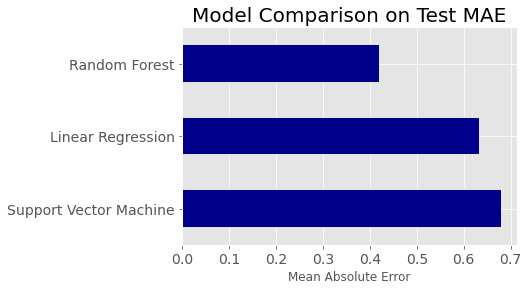

In [30]:
#Compare our model on basis of Mean absolute error
style.use('ggplot')
model_comparison = pd.DataFrame({"model": ["Linear Regression", "Support Vector Machine","Random Forest"],
                                 "mae": [ln_mae, svm_mae, rf_mae]})

model_comparison.sort_values("mae", ascending=False).plot(x="model", y="mae", kind="barh",
                                                           color="darkblue", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Mean Absolute Error"); plt.xticks(size=14)
plt.title("Model Comparison on Test MAE", size=20);

# We found that the RandomForest Regressor works the best among the three. 
# Not only Mean absolute error is less for RandomForestRegressor,the root mean square is also less and R2 is more.

In [31]:
#We need to see the feature importance of the model to find out which features are the most important ones in explaining the results.
New_df = pd.DataFrame(list(zip(X_train.columns, random_forest.feature_importances_)),columns = ['features', 'Importance'])
New_df

,features,Importance
0,Year_of_Release,9.681031e-02
1,Critic_Score,1.088427e-01
2,Critic_Count,8.851325e-02
3,User_Score,6.313573e-02
4,User_Count,2.548913e-01
5,Platform_3DS,4.307967e-03
6,Platform_DC,1.285220e-04
7,Platform_DS,4.622038e-02
8,Platform_GBA,1.215330e-03
9,Platform_GC,5.088073e-04


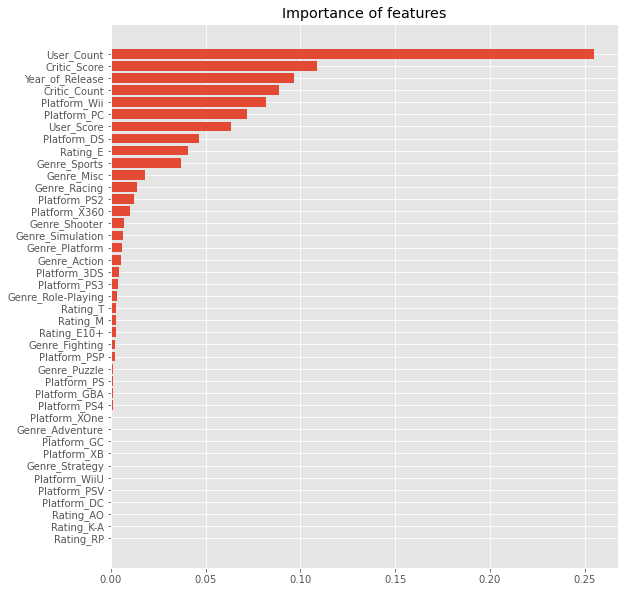

In [32]:
# Plot feature importance
sorted_idx = np.argsort(New_df.Importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig3=plt.figure(figsize=(20,10))
sub=fig3.add_subplot(1,2,2)
plt.barh(pos, New_df.Importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns.values[sorted_idx])
plt.title("Importance of features")
fig3.show()

let's get to the real question: is the model good or not?

Well, it depends on the point of view. If you would use this model to forecast the unit sales of a small video game developer's game, the model may not be as good. The reason is that typically independent smaller studios sell under a million copies. Since the accuracy of this model is low, a high margin of error can have a tremendous financial impact on the company, if you are relying on forecasting sales with this model. However, if you use this model to forecast the unit sales of larger AAA game developer's game, a higher margin of error, isn't that fatal. If you're forecasting the unit sales of a developer who typically sells say 3 million copies, then a roughly 10 % deviation is not fatal. Sure it isn't close to perfect, but these type of models typically aren't.